<a href="https://colab.research.google.com/github/atstuyuki/elbow_OCD/blob/main/EfficientNet_train_original_data_20220729.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##EfficientNetで独自画像の分類
https://farml1.com/efficientnet/

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import seaborn as sns

In [ ]:
#googleドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


googleドライブにマウントしたフォルダから訓練データとテストデータの読み取り

In [ ]:
IMAGE_SHAPE = (64, 64)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,  validation_split = 0.3) #0.3を変更することでval_dataの枚数を変更可能です
train_data = image_generator.flow_from_directory("/content/drive/MyDrive/elbow_OCD/train", target_size=IMAGE_SHAPE, subset = "training" )
val_data = image_generator.flow_from_directory("/content/drive/MyDrive/elbow_OCD/test", target_size=IMAGE_SHAPE, subset = "validation" )

Found 1054 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


In [ ]:
for train_batch, train_label_batch in train_data:
  print("train_Image batch shape: ", train_batch.shape)
  print("train_Label batch shape: ", train_label_batch.shape)
  break
for val_batch, val_label_batch in val_data:
  print("val_Image batch shape: ", val_batch.shape)
  print("val_Label batch shape: ", val_label_batch.shape)
  break

train_Image batch shape:  (32, 64, 64, 3)
train_Label batch shape:  (32, 2)
val_Image batch shape:  (32, 64, 64, 3)
val_Label batch shape:  (32, 2)


In [ ]:
#モデルをロードする
feature_extractor_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1" #B0を選定
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(64,64,3))
feature_extractor_layer.trainable = False #学習済み重みは固定するのでFalse

In [ ]:
#モデルの構築
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(train_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4049564   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 2,562
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.01),
  loss='categorical_crossentropy',
  metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#学習実施
epochs = 50
train_steps_per_epoch = np.ceil(train_data.samples/train_data.batch_size)
val_steps_per_epoch = np.ceil(val_data.samples/val_data.batch_size)

#batch_stats_callback = CollectBatchStats()

history = model.fit(train_data, epochs=epochs,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_data,
                    validation_steps=val_steps_per_epoch)

Epoch 1/50
33/33 [==============================] - 406s 12s/step - loss: 0.0803 - acc: 0.9658 - val_loss: 0.2826 - val_acc: 0.9355
Epoch 2/50
33/33 [==============================] - 34s 1s/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.5203 - val_acc: 0.9355
Epoch 3/50
33/33 [==============================] - 33s 1s/step - loss: 3.3773e-04 - acc: 1.0000 - val_loss: 0.4886 - val_acc: 0.9355
Epoch 4/50
33/33 [==============================] - 34s 1s/step - loss: 2.3403e-04 - acc: 1.0000 - val_loss: 0.4727 - val_acc: 0.9355
Epoch 5/50
33/33 [==============================] - 35s 1s/step - loss: 2.0124e-04 - acc: 1.0000 - val_loss: 0.4732 - val_acc: 0.9355
Epoch 6/50
33/33 [==============================] - 34s 1s/step - loss: 1.8048e-04 - acc: 1.0000 - val_loss: 0.4718 - val_acc: 0.9355
Epoch 7/50
33/33 [==============================] - 34s 1s/step - loss: 1.6119e-04 - acc: 1.0000 - val_loss: 0.4632 - val_acc: 0.9355
Epoch 8/50
33/33 [==============================] - 36s 1s/step - lo

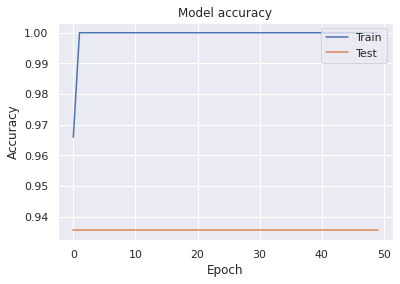

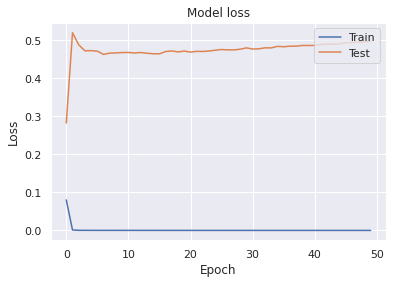

In [ ]:
sns.set()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

##モデルの推論

In [ ]:
class_names = sorted(train_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['0_Normal', '1_Ocd'], dtype='<U8')

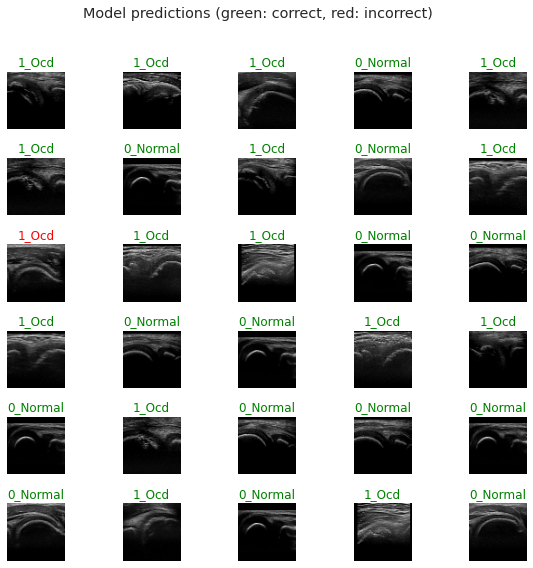

In [ ]:
predicted_batch = model.predict(val_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(val_label_batch, axis=-1)
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

#モデルを保存する
https://qiita.com/sn6/items/f9773fb1917cfd4bd1d4

In [ ]:
model

In [ ]:
#h5形式でのモデルの保存
model.save('trained_efiicientnet_ocd_20220727.h5')

↑h5形式のモデルが読み込めないので（もともとの層が一塊として認識？
https://book-read-yoshi.hatenablog.com/entry/2021/09/23/grad-cam/efficientnet/tensorflow
層を分解してモデルを作成すればうまくいくかも
https://farml1.com/grad-cam/

In [ ]:
#SavedModel形式で保存
model.save('/content/drive/MyDrive/elbow_OCD/trained_efiicientnet_ocd_20220727', save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/elbow_OCD/trained_efiicientnet_ocd_20220727/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/elbow_OCD/trained_efiicientnet_ocd_20220727/assets


In [ ]:
#saved Model形式の読み込みフォルダのパスを渡す
new_model = tf.keras.models.load_model('/content/trained_efiicientnet_ocd_20220727')

In [ ]:
new_model

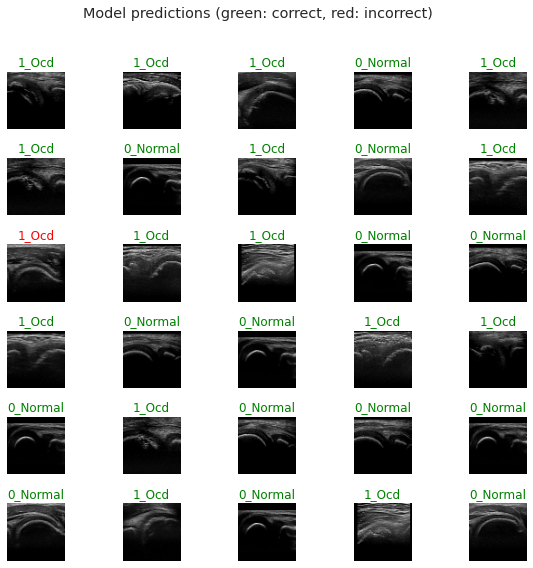

In [ ]:
#読み込んだnewモデルで分類
predicted_batch = new_model.predict(val_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(val_label_batch, axis=-1)
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
#confusion matrixを描く
https://androidkt.com/keras-confusion-matrix-in-tensorboard/